In [ ]:
import pandas as pd
import os
import glob
import matplotlib.ticker as ticker
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
import os
from matplotlib.ticker import MaxNLocator

In [3]:
import os
import glob
import pandas as pd

pkl_dir = '/data/users2/jwardell1/undersampling-project/HCP/pkl-files'
#pkl_dir = '/data/users2/jwardell1/undersampling-project/OULU/pkl-files'

# Read and concatenate sr1 data
joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
joined_list = glob.glob(joined_files)
sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

# Read and concatenate sr2 data
joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
joined_list = glob.glob(joined_files)
sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

# Read and concatenate concat data
joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
joined_list = glob.glob(joined_files)
concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

# Read and concatenate add data
joined_files = os.path.join(pkl_dir, 'add_*.pkl')
joined_list = glob.glob(joined_files)
add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

# Concatenate all dataframes
all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)



In [14]:
all_data

,graph_no,nstd,burnin,noise_no,snr,scalar,classifier,test_scores,target,predictions,test_proba,sampling_rate
0,2,1.0,100,0,0.5,0.562341,Logistic Regression,0 0.969904 1 0.969767 2 0.980575 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",0 0.017833 1 0.081309 2 0.06...,sr1
1,2,1.0,100,0,0.5,0.562341,Multilayer Perceptron,0 0.973324 1 0.955677 2 0.969767 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",0 1.333632e-04 1 2.330788e-03 2 ...,sr1
2,2,1.0,100,0,0.5,0.562341,Naive Bayes,0 0.715595 1 0.722298 2 0.777018 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",0 5.099987e-142 1 1.000000e+00 2 ...,sr1
3,2,1.0,100,0,0.5,0.562341,SVM,0 0.95814 1 0.945691 2 0.981806 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0 0.021053 1 0.149037 2 0.03...,sr1
4,2,1.0,100,1,0.5,0.562341,Logistic Regression,0 0.969904 1 0.969767 2 0.980575 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",0 0.017833 1 0.081309 2 0.06...,sr1
...,...,...,...,...,...,...,...,...,...,...,...,...
2075,77,1.0,100,3,1.0,0.316228,SVM,0 0.911902 1 0.890424 2 0.825171 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0 0.188727 1 0.538806 2 0.33...,add
2076,77,1.0,100,4,1.0,0.316228,Logistic Regression,0 0.885089 1 0.870451 2 0.880164 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",0 0.243582 1 0.147512 2 0.63...,add
2077,77,1.0,100,4,1.0,0.316228,Multilayer Perceptron,0 0.891655 1 0.880301 2 0.868399 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",0 0.041884 1 0.326744 2 0.86...,add
2078,77,1.0,100,4,1.0,0.316228,Naive Bayes,0 0.64186 1 0.668536 2 0.585363 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",0 4.616665e-17 1 1.000000e+00 2 ...,add


In [90]:
all_data.to_csv('all_data.csv')

In [4]:
import pandas as pd

# Function to split each row into multiple rows based on cross-validation index
def split_row(row):
    new_rows = []
    for cv_ix, auc in enumerate(row['test_scores']):
        new_row = row.copy()
        new_row['auc'] = auc
        new_row['cv_ix'] = cv_ix
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# Apply the split_row function to each row of the dataframe and concatenate the results
result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)

# Drop the original 'test_scores' column as it's no longer needed
result_df.drop('test_scores', axis=1, inplace=True)


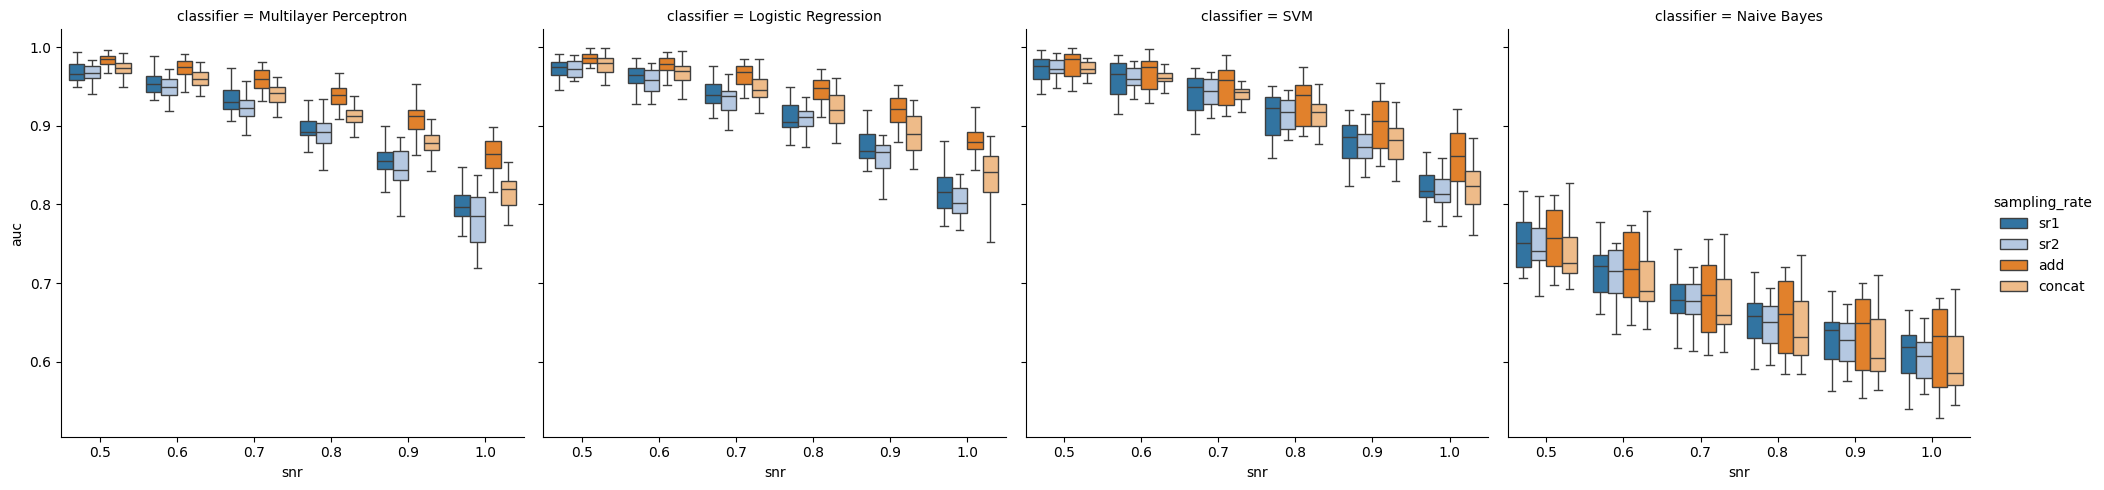

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group result_df by 'classifier'
grouped_classifiers = result_df.groupby('classifier')

# Create separate dataframes for each classifier
classifier_dfs = {}
for classifier, group_df in grouped_classifiers:
    classifier_dfs[classifier] = group_df.copy()

mlp_df = classifier_dfs['Multilayer Perceptron']
lr_df = classifier_dfs['Logistic Regression']
svm_df = classifier_dfs['SVM']
nb_df = classifier_dfs['Naive Bayes']

dfs = [mlp_df, lr_df, svm_df, nb_df]

snr_levels = ['0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = { item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

# Combine all dataframes into one dataframe for plotting
combined_df = pd.concat(dfs)

# Plot all boxplots in one plot using catplot
ax = sns.catplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    col="classifier",
    data=combined_df,
    kind="box",
    palette=palette,
    showfliers=False
)




plt.savefig('all.png')




In [9]:
!pip install statannotations

p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02



AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

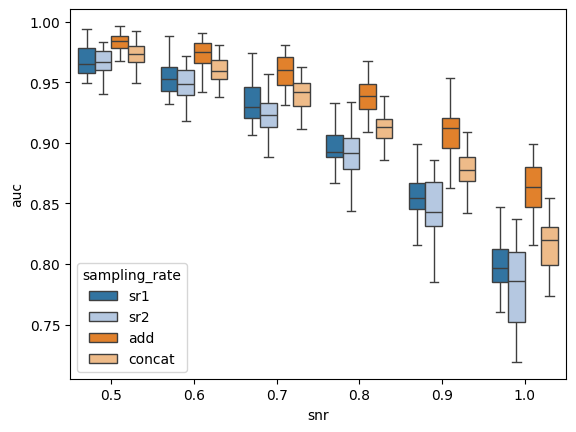

In [28]:
# Plot all boxplots in one plot using catplot
ax = sns.boxplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    data=mlp_df,
    palette=palette,
    showfliers=False
)


from statannot import add_stat_annotation


#pairs = [((dataset, "Mean MLP"), (dataset, "DICE")) for dataset in ica_datasets]
pairs = [((snr_level, "0.5"), (snr_level, "1.0")) for snr_level in snr_levels]

add_stat_annotation(
    ax, 
    box_pairs=pairs,
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    data=combined_df,
    test='Wilcoxon',
    text_format='star',
    loc='inside', 
    verbose=1, 
    text_offset=-4,
    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
)